In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
import networkx as nx
from sklearn import preprocessing
from sklearn.metrics import accuracy_score


from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG

In [7]:
geo_data = pd.read_csv('hackathon.csv')
geo_data.head(10)

,Reservoir unit,Latitude,Longitude,Tectonic regime,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,ARAB D,26.0800,49.8100,COMPRESSION/EVAPORITE,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
1,BAHARIYA,29.7422,28.4925,EXTENSION,ONSHORE,GAS-CONDENSATE,MATURE PRODUCTION,RIFT,10282,CRETACEOUS,SANDSTONE,745.0,144.0,10.0,8.0
2,ABU MADI (LEVEL II),31.4382,31.3616,STRIKE-SLIP/TRANSTENSION/SHALE/EVAPORITE/BASEM...,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH/DELTA,9843,NEOGENE,THINLY-BEDDED SANDSTONE,115.0,66.0,22.0,200.0
3,ABU MADI (LEVEL III),31.4382,31.3616,STRIKE-SLIP/TRANSTENSION/SHALE/EVAPORITE/BASEM...,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH/DELTA,10499,NEOGENE,SANDSTONE,509.0,410.0,20.0,300.0
4,SHUAIBA,21.9607,56.0452,COMPRESSION/EVAPORITE,ONSHORE,OIL,REJUVENATING,SALT/FORELAND,4955,CRETACEOUS,LIMESTONE,250.0,100.0,21.0,60.0
5,UPPER GLEN ROSE D ZONE,31.2143,-95.7981,GRAVITY/EXTENSION/EVAPORITE,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0
6,ALBA,58.0692,1.0784,NaN,OFFSHORE,OIL,DECLINING PRODUCTION,RIFT,5642,PALEOGENE,THINLY-BEDDED SANDSTONE,300.0,270.0,NaN,3500.0
7,TRENTON-BLACK RIVER,41.9937,-84.6016,NaN,ONSHORE,OIL,NEARLY DEPLETED,INTRACRATONIC,3800,ORDOVICIAN,DOLOMITE,600.0,400.0,NaN,10.0
8,KT I,48.4740,57.6667,COMPRESSION/EVAPORITE,ONSHORE,OIL,DEVELOPING,SUB-SALT/FORELAND,6000,CARBONIFEROUS,LIMESTONE,300.0,105.0,10.0,20.0
9,KT II,48.4740,57.6667,COMPRESSION/EVAPORITE,ONSHORE,OIL,DEVELOPING,SUB-SALT/FORELAND,9580,CARBONIFEROUS,LIMESTONE,607.0,108.0,10.0,20.0


In [8]:
geo_data.dropna(inplace=True)
geo_data.reset_index(inplace=True, drop=True)

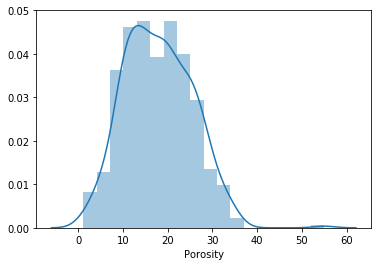

In [9]:
sns.distplot(geo_data['Porosity'])

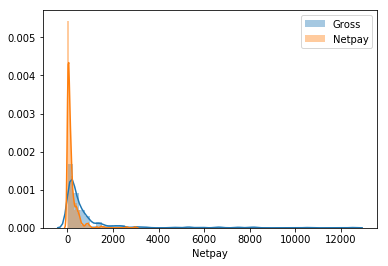

In [10]:
sns.distplot(geo_data['Gross'],label='Gross')
sns.distplot(geo_data['Netpay'], label='Netpay')
plt.legend()

In [12]:
geo_data = geo_data[['Depth', 'Gross', 'Netpay', 'Porosity', 'Permeability', 'Structural setting','Period', 'Lithology',
                                    'Tectonic regime', 'Hydrocarbon type']]

In [13]:
geo_data.head(10)

,Depth,Gross,Netpay,Porosity,Permeability,Structural setting,Period,Lithology,Tectonic regime,Hydrocarbon type
0,6050,250.0,184.0,21.0,410.0,FORELAND,JURASSIC,LIMESTONE,COMPRESSION/EVAPORITE,OIL
1,10282,745.0,144.0,10.0,8.0,RIFT,CRETACEOUS,SANDSTONE,EXTENSION,GAS-CONDENSATE
2,9843,115.0,66.0,22.0,200.0,WRENCH/DELTA,NEOGENE,THINLY-BEDDED SANDSTONE,STRIKE-SLIP/TRANSTENSION/SHALE/EVAPORITE/BASEM...,GAS
3,10499,509.0,410.0,20.0,300.0,WRENCH/DELTA,NEOGENE,SANDSTONE,STRIKE-SLIP/TRANSTENSION/SHALE/EVAPORITE/BASEM...,GAS
4,4955,250.0,100.0,21.0,60.0,SALT/FORELAND,CRETACEOUS,LIMESTONE,COMPRESSION/EVAPORITE,OIL
5,8700,95.0,15.0,12.0,20.0,PASSIVE MARGIN,CRETACEOUS,LIMESTONE,GRAVITY/EXTENSION/EVAPORITE,OIL
6,6000,300.0,105.0,10.0,20.0,SUB-SALT/FORELAND,CARBONIFEROUS,LIMESTONE,COMPRESSION/EVAPORITE,OIL
7,9580,607.0,108.0,10.0,20.0,SUB-SALT/FORELAND,CARBONIFEROUS,LIMESTONE,COMPRESSION/EVAPORITE,OIL
8,6600,50.0,49.0,20.0,15.0,FORELAND,JURASSIC,SANDSTONE,COMPRESSION,OIL
9,15250,8000.0,575.0,5.0,0.1,FORELAND,PALEOGENE,SANDSTONE,COMPRESSION,OIL


In [14]:
for column in ['Structural setting','Period', 'Lithology','Tectonic regime', 'Hydrocarbon type']:
    le = preprocessing.LabelEncoder()
    geo_data[column] = le.fit_transform(geo_data[column].values)




In [15]:
geo_data.head(10)

,Depth,Gross,Netpay,Porosity,Permeability,Structural setting,Period,Lithology,Tectonic regime,Hydrocarbon type
0,6050,250.0,184.0,21.0,410.0,7,12,9,5,5
1,10282,745.0,144.0,10.0,8.0,23,7,11,21,3
2,9843,115.0,66.0,22.0,200.0,46,15,15,57,2
3,10499,509.0,410.0,20.0,300.0,46,15,11,57,2
4,4955,250.0,100.0,21.0,60.0,27,7,9,5,5
5,8700,95.0,15.0,12.0,20.0,21,7,9,35,5
6,6000,300.0,105.0,10.0,20.0,33,4,9,5,5
7,9580,607.0,108.0,10.0,20.0,33,4,9,5,5
8,6600,50.0,49.0,20.0,15.0,7,12,11,0,5
9,15250,8000.0,575.0,5.0,0.1,7,17,11,0,5


In [16]:
transformed_data = copy(geo_data)
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(geo_data.values[:,0:5])
transformed_data[['Depth',	'Gross',	'Netpay',	'Porosity',	'Permeability']] = data_discrete

In [17]:
hc = HillClimbSearch(transformed_data, scoring_method=K2Score(transformed_data))

In [18]:
best_model = hc.estimate()

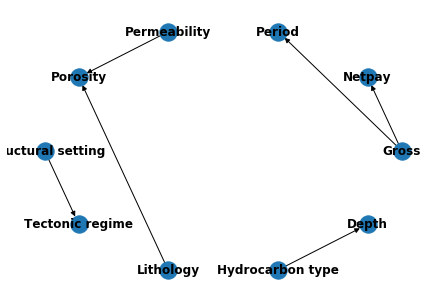

In [19]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [25]:
def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [29]:
accuracy_k2 = accuracy_params_restoration(BayesianModel(best_model.edges()), transformed_data)

imination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?

In [30]:
accuracy_k2

,Parameter,accuracy
0,Depth,0.366516
1,Gross,0.873303
2,Netpay,0.696833
3,Porosity,0.524887
4,Permeability,0.882353
5,Structural setting,0.653846
6,Period,0.285068
7,Lithology,0.581448
8,Tectonic regime,0.540724
9,Hydrocarbon type,0.755656
